In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score


In [3]:

# Load the data
email_table = pd.read_csv('/content/email_table.csv')
email_opened_table = pd.read_csv('/content/email_opened_table.csv')
link_clicked_table = pd.read_csv('/content/link_clicked_table.csv')

# Create a copy of the email table and add flags for opened and clicked
email_data = email_table.copy()
email_data['opened'] = email_data['email_id'].isin(email_opened_table['email_id']).astype(int)
email_data['clicked'] = email_data['email_id'].isin(link_clicked_table['email_id']).astype(int)

# Calculate percentages
total_emails = len(email_data)
opened_emails = email_data['opened'].sum()
clicked_links = email_data['clicked'].sum()

percentage_opened = (opened_emails / total_emails) * 100
percentage_clicked = (clicked_links / total_emails) * 100
ctr_for_opened = (email_data[email_data['opened'] == 1]['clicked'].sum() / opened_emails) * 100

print(f"Total emails sent: {total_emails}")
print(f"Number of emails opened: {opened_emails} ({percentage_opened:.2f}%)")
print(f"Number of links clicked: {clicked_links} ({percentage_clicked:.2f}%)")
print(f"Click-through rate for opened emails: {ctr_for_opened:.2f}%")


Total emails sent: 100000
Number of emails opened: 10345 (10.35%)
Number of links clicked: 2119 (2.12%)
Click-through rate for opened emails: 20.00%


In [4]:
bins = [-1, 5, 10, 15, 22]  # -1 to include 0
labels = ['0-5', '6-10', '11-15', '16-22']

email_data['purchase_bins'] = pd.cut(
    email_data['user_past_purchases'],
    bins=bins,
    labels=labels
)



In [5]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
email_data['purchase_bins_encoded'] = le.fit_transform(email_data['purchase_bins'])


In [6]:
le = LabelEncoder()
email_data['weekday_encoded'] = le.fit_transform(email_data['weekday'])
email_data


,email_id,email_text,email_version,hour,weekday,user_country,user_past_purchases,opened,clicked,purchase_bins,purchase_bins_encoded,weekday_encoded
0,85120,short_email,personalized,2,Sunday,US,5,0,0,0-5,0,3
1,966622,long_email,personalized,12,Sunday,UK,2,1,1,0-5,0,3
2,777221,long_email,personalized,11,Wednesday,US,2,0,0,0-5,0,6
3,493711,short_email,generic,6,Monday,UK,1,0,0,0-5,0,1
4,106887,long_email,generic,14,Monday,US,6,0,0,6-10,3,1
...,...,...,...,...,...,...,...,...,...,...,...,...
99995,803504,short_email,personalized,4,Monday,US,5,0,0,0-5,0,1
99996,899722,long_email,personalized,7,Saturday,US,1,0,0,0-5,0,2
99997,449610,long_email,personalized,11,Saturday,UK,6,0,0,6-10,3,2
99998,72497,short_email,generic,10,Monday,UK,0,0,0,0-5,0,1


In [7]:
email_data['email_text_encoded'] = email_data['email_text'].apply(lambda x: 1 if x == 'long_email' else 0)
email_data['email_version_encoded'] = email_data['email_version'].apply(lambda x : 1 if x == 'personalized' else 0 )
# Create mapping based on frequency
country_map = {
    'US': 0,
    'UK': 1,
    'FR': 2,
    'ES': 3
}

# Apply the mapping
email_data['user_country_encoded'] = email_data['user_country'].map(country_map)


In [9]:
email_data.to_csv("preprocessed_data.csv")

CTR by Email Format:
email_version   generic  personalized
email_text                           
long_email     1.371057      2.340256
short_email    1.657790      3.123106


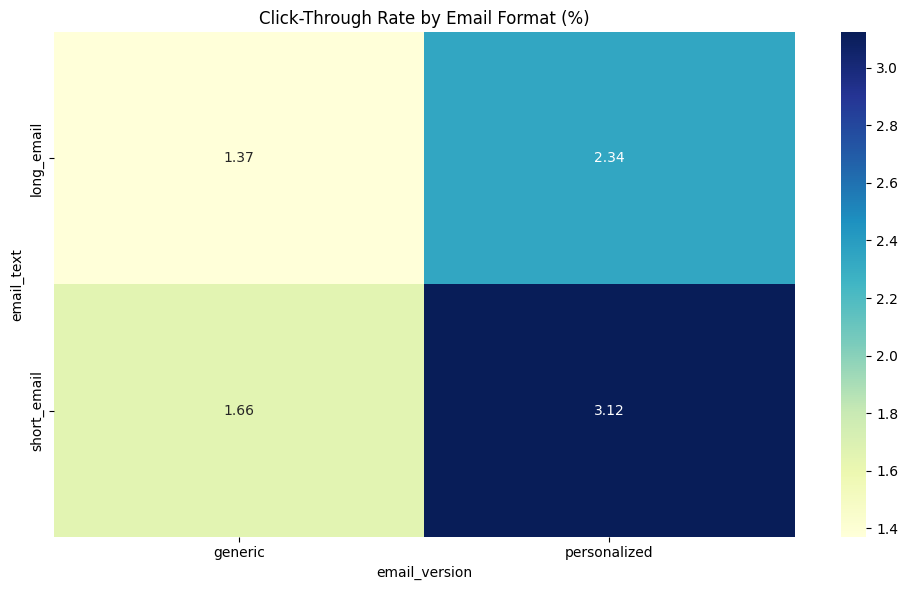

In [10]:

# Analyze text length and personalization impact
text_version_ctr = email_data.groupby(['email_text', 'email_version'])['clicked'].mean() * 100
text_version_pivot = text_version_ctr.reset_index().pivot(index='email_text',
                                                         columns='email_version',
                                                         values='clicked')

print("CTR by Email Format:")
print(text_version_pivot)

plt.figure(figsize=(10, 6))
sns.heatmap(text_version_pivot, annot=True, fmt='.2f', cmap='YlGnBu')
plt.title('Click-Through Rate by Email Format (%)')
plt.tight_layout()

CTR by Purchase History and Email Version:
email_version   generic  personalized
purchase_bins                        
0-5            0.916726      1.823119
6-10           2.766532      4.530387
11-15          4.886174      8.442982
16-22          8.474576     12.727273


<ipython-input-13-fc5d9cb62d48>:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  purchase_version_ctr = email_data.groupby(['purchase_bins', 'email_version'])['clicked'].mean() * 100


<Figure size 1200x600 with 0 Axes>

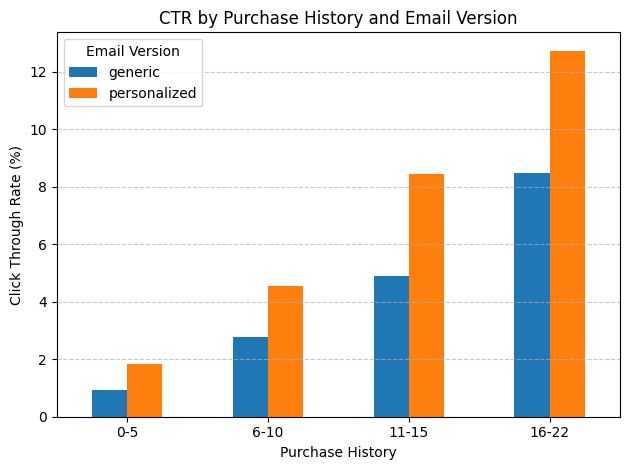

In [13]:

# Group by purchase bins and email version, and calculate mean CTR
purchase_version_ctr = email_data.groupby(['purchase_bins', 'email_version'])['clicked'].mean() * 100

# Reset and pivot for easier plotting
purchase_version_df = purchase_version_ctr.reset_index().pivot(index='purchase_bins',
                                                               columns='email_version',
                                                               values='clicked')

# Print CTR table
print("CTR by Purchase History and Email Version:")
print(purchase_version_df)

# Plotting
plt.figure(figsize=(12, 6))
purchase_version_df.plot(kind='bar')
plt.title('CTR by Purchase History and Email Version')
plt.ylabel('Click Through Rate (%)')
plt.xlabel('Purchase History')
plt.xticks(rotation=0)
plt.legend(title='Email Version')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

Text(0, 0.5, 'CTR (%)')

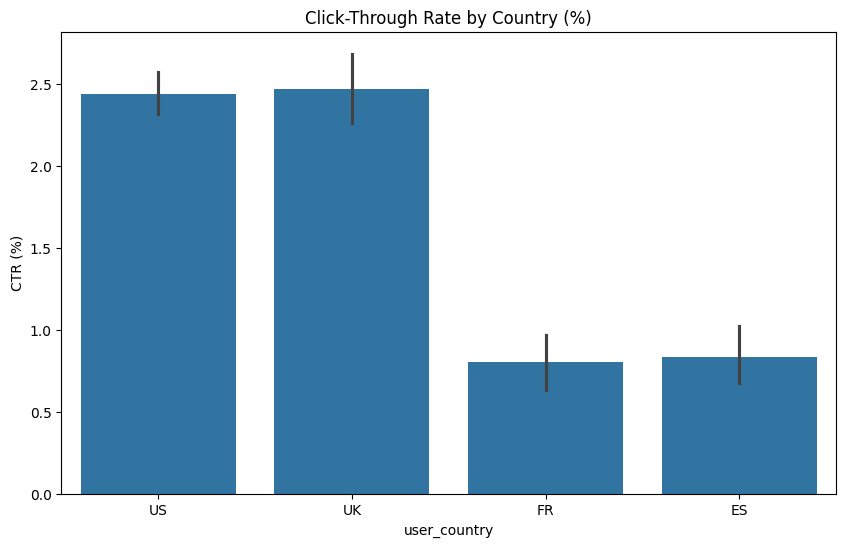

In [14]:
# Analyze CTR by country and email version
country_version_ctr = email_data.groupby(['user_country', 'email_version'])['clicked'].mean() * 100
country_version_df = country_version_ctr.reset_index().pivot(index='user_country',
                                                            columns='email_version',
                                                            values='clicked')

plt.figure(figsize=(10, 6))
sns.barplot(x='user_country', y='clicked', data=email_data, estimator=lambda x: sum(x)*100/len(x))
plt.title('Click-Through Rate by Country (%)')
plt.ylabel('CTR (%)')


<ipython-input-15-595cfc51bf92>:8: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  weekday_hour_ctr = email_data.groupby(['weekday', 'hour_bin'])['clicked'].mean() * 100


CTR by Weekday and Time of Day:
hour_bin   Night (0-6)  Morning (6-12)  Afternoon (12-18)  Evening (18-24)
weekday                                                                   
Friday        1.030928        1.548541           1.659452         1.234568
Monday        2.090993        2.487635           2.134472         2.147239
Saturday      1.644515        1.787808           1.897019         2.542373
Sunday        1.436848        1.979910           1.297335         1.709402
Thursday      1.788171        2.841737           2.582757         1.644737
Tuesday       1.931379        2.871392           2.652330         0.895522
Wednesday     2.321876        3.241590           2.534809         1.142857


Text(158.22222222222223, 0.5, 'Weekday')

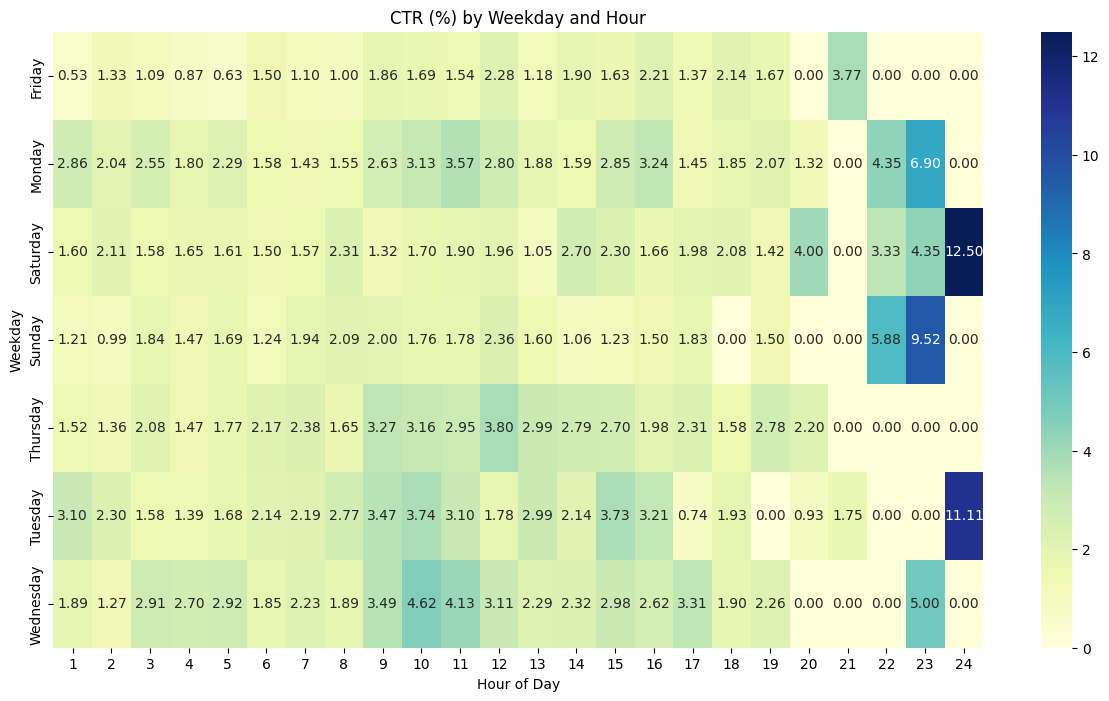

In [15]:
# Create time of day bins
email_data['hour_bin'] = pd.cut(email_data['hour'],
                               bins=[0, 6, 12, 18, 24],
                               labels=['Night (0-6)', 'Morning (6-12)',
                                       'Afternoon (12-18)', 'Evening (18-24)'])

# Analyze weekday and time of day
weekday_hour_ctr = email_data.groupby(['weekday', 'hour_bin'])['clicked'].mean() * 100
weekday_hour_df = weekday_hour_ctr.unstack()

print("CTR by Weekday and Time of Day:")
print(weekday_hour_df)

# Heatmap of weekday and hour
weekday_hour_detail = email_data.groupby(['weekday', 'hour'])['clicked'].mean() * 100
weekday_hour_pivot = weekday_hour_detail.reset_index().pivot(index='weekday',
                                                            columns='hour',
                                                            values='clicked')

plt.figure(figsize=(15, 8))
sns.heatmap(weekday_hour_pivot, cmap='YlGnBu', annot=True, fmt='.2f')
plt.title('CTR (%) by Weekday and Hour')
plt.xlabel('Hour of Day')
plt.ylabel('Weekday')


In [17]:
# Find best overall combinations
segment_ctr = email_data.groupby(['email_text', 'email_version', 'weekday', 'purchase_bins'])['clicked'].mean() * 100
top_segments = segment_ctr.sort_values(ascending=False).head(10)
print("Top Performing Segments:")
top_segments


Top Performing Segments:


<ipython-input-17-20ec6482db17>:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  segment_ctr = email_data.groupby(['email_text', 'email_version', 'weekday', 'purchase_bins'])['clicked'].mean() * 100


email_text   email_version  weekday    purchase_bins
long_email   generic        Tuesday    16-22            57.142857
             personalized   Monday     16-22            33.333333
                            Thursday   16-22            25.000000
short_email  generic        Wednesday  16-22            22.222222
             personalized   Saturday   16-22            20.000000
long_email   personalized   Saturday   16-22            20.000000
short_email  generic        Tuesday    16-22            16.666667
long_email   personalized   Wednesday  16-22            16.666667
short_email  personalized   Tuesday    16-22            15.384615
long_email   generic        Saturday   16-22            14.285714
Name: clicked, dtype: float64